# Обучающие автоэнкодеры и шумопонижающие автоэнкодеры
### Применение к набору данных MNIST

#### Настройки

In [1]:
%cd ../code/NN/

/home/greed/Projects/Education/Python/education-deep-learning/code/NN


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from autoencoder import Autoencoder
from nn.nn import NN
from nn.utils import load_data, binarize_data
from nn.visualization import print_image

#### Загрузка и бинаризация данных

In [3]:
X_train, X_valid, X_test, y_train, y_valid, y_test = \
    load_data('../../data/digitstrain.txt',
              '../../data/digitsvalid.txt',
              '../../data/digitstest.txt')

In [4]:
X_train.shape, y_train.shape

((3000, 784), (3000, 10))

In [5]:
X_train = binarize_data(X_train)
X_valid = binarize_data(X_valid)
X_test  = binarize_data(X_test)

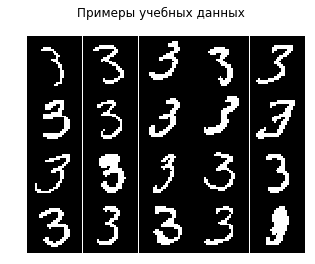

In [6]:
print_image(X_train[1160:1180, :], output_shape=(4, 5), 
            title='Примеры учебных данных')
None # должен быть двоичным

## (e) Автоэнкодеры

### Инициализация модели

Массивы $W \in \mathbb{R}^{n_{hidden} \times n_{visible}}$ инициализируются из a $\mathrm{Unif}(-u, u)$, где $u = \frac{\sqrt{6}}{\sqrt{n_{visible}+n_{hidden}}}$, как описано в лекции. Cмещения инициализируются нулем.

Уровень обучения инициализируется равным 0,1 и уменьшается через каждые 100 эпох.

In [7]:
ae = Autoencoder(n_visible=784, n_hidden=100, binary=True,
                 activation='sigmoid', denoising=0.0,
                 learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                 early_stopping=True, seed=0)

In [8]:
ae.W.shape, ae.b.shape, ae.c.shape

((100, 784), (100, 1), (784, 1))

In [9]:
[l.__name__ for l in ae.layers]

['AE_input_layer', 'AE_output_layer']

### Обучение

Тренируется меньшее количество эпох для автоэнкодеров по сравнению с RBM's, поскольку они, как представляется, демонстрируют хорошую производительность реконструкции (которая является их основной целью) раньше, чем RBM.

In [10]:
n_epoch = 200
ae.train(X_train, X_valid,
         batch_size=200, n_epoch=n_epoch, batch_seed=25, 
         verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         254.23563         |         255.99015         |
|    2  |         148.13829         |         149.46294         |
|    3  |         133.92771         |         135.74770         |
|    4  |         124.81054         |         126.99349         |
|    5  |         117.97219         |         120.34700         |
|    6  |         112.68816         |         115.28634         |
|    7  |         108.15671         |         110.97000         |
|    8  |         104.57765         |         107.59971         |
|    9  |         101.30716         |         104.57972         |
|   10  |          98.40196         |         101.91343         |
|   11  | 

|  121  |          52.76228         |          66.30259         |
|  122  |          52.69917         |          66.25090         |
|  123  |          52.64362         |          66.24375         |
|  124  |          52.59422         |          66.18798         |
|  125  |          52.51621         |          66.18228         |
|  126  |          52.46027         |          66.11938         |
|  127  |          52.39970         |          66.08237         |
|  128  |          52.33945         |          66.05311         |
|  129  |          52.28997         |          66.04079         |
|  130  |          52.22066         |          65.99636         |
|  131  |          52.16511         |          65.95343         |
|  132  |          52.09849         |          65.93754         |
|  133  |          52.03776         |          65.86752         |
|  134  |          51.98712         |          65.86457         |
|  135  |          51.93732         |          65.82616         |
|  136  | 

Затем отображаются графики ошибок обучения и проверки. Ошибка проверки начинается с плато после 100 эпох.

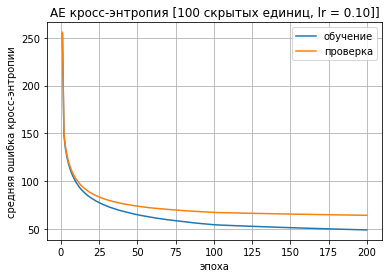

In [11]:
plt.grid()
plt.plot(*zip(*ae.training_error), label='обучение')
plt.plot(*zip(*ae.validation_error), label='проверка')
plt.title('AE кросс-энтропия [100 скрытых единиц, lr = {:.2f}]]'.format(ae.learning_rate.const))
plt.xlabel('эпоха')
plt.ylabel('средняя ошибка кросс-энтропии')
plt.legend()
plt.show()

### Визуализация параметров

Берутся первые скрытые единицы слоя и почемаются как изображения. Как показано ниже, фильтры, похоже, захватывают фигуры в виде цифр.

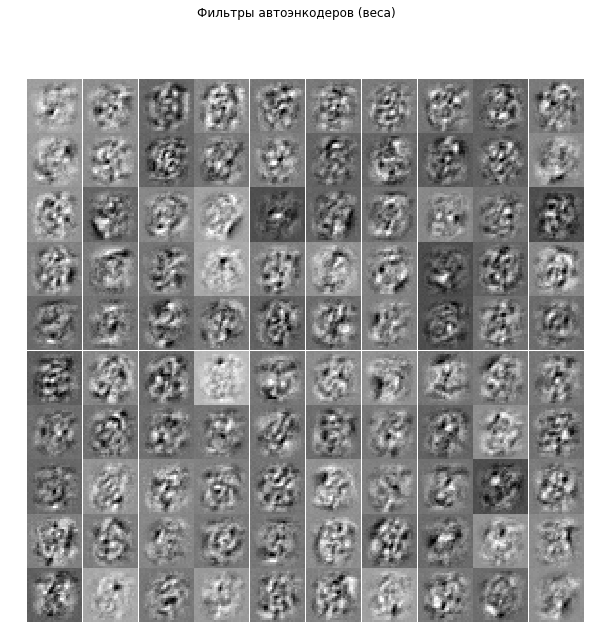

In [12]:
assert ae.W.shape[0] >= 100
print_image(ae.W[:100,:], output_shape=(10, 10),
            title='Фильтры автоэнкодеров (веса)')
None

Фильтры немного размыты, чем у RBM, как и ожидалось. Denoising autoencoders может помочь (позже), если хочется получить более четкие фильтры.

Cоздаем 25 реконструкций по невидимым данным с использованием обученного AE. Качество реконструкции на удивление хорошо.

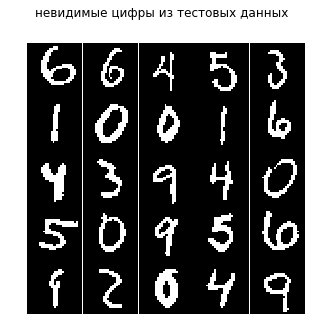

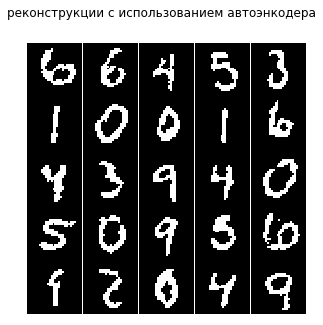

In [13]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_test.shape[0]), 25, replace=False)

X_rec = ae.reconstruct(X_test[subset, :])
print_image(X_test[subset], output_shape=(5, 5),
            title='невидимые цифры из тестовых данных')
print_image(X_rec, output_shape=(5, 5),
            title='реконструкции с использованием автоэнкодера')
None

### Автоэнкодеры для предварительной подготовки

Обучение 1-слойной нейронной сети с весами, полученными из AE, и сравнивае их со случайным образом инициализированным весом.

In [14]:
# Случайная инициализация
nn_random = NN(architecture=[784, 100, 10], 
               activation='sigmoid', learning_rate=0.01, momentum=0.7,
               weight_decay=1e-4, dropout=0.0, early_stopping=True, 
               seed=40)
nn_random.train(X_train, y_train, X_valid, y_valid,
                batch_size=200, n_epoch=n_epoch, batch_seed=25,
                verbose=False)  # silent run
None

In [15]:
# Инициализация с использованием AE
nn_ae = NN(architecture=[784, 100, 10], 
           activation='sigmoid', learning_rate=0.01, momentum=0.7,
           weight_decay=1e-4, dropout=0.0, early_stopping=True, 
           seed=40)
nn_ae.layers[0].W = ae.W
nn_ae.train(X_train, y_train, X_valid, y_valid,
            batch_size=200, n_epoch=n_epoch, batch_seed=25,
            verbose=False)  # silent run
None

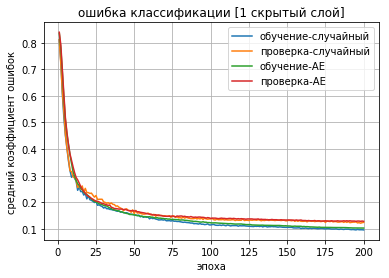

In [16]:
# Частота ошибок
plt.grid()
plt.plot(*zip(*nn_random.training_error), label='обучение-случайный')
plt.plot(*zip(*nn_random.validation_error), label='проверка-случайный')
plt.plot(*zip(*nn_ae.training_error), label='обучение-AE')
plt.plot(*zip(*nn_ae.validation_error), label='проверка-AE')
plt.title('ошибка классификации [1 скрытый слой]')
plt.xlabel('эпоха')
plt.ylabel('средний коэффициент ошибок')
plt.legend()
plt.show()

Предварительно прошедшие предварительную проверку веса автоматически помогают достичь более низкой частоты ошибок в начале. В конечном счете, случайным образом инициализированный NN следует за AE-инициализированным NN для достижения той же частоты ошибок. Результат лучше, чем версия, предварительно обработанная RBM, которая на самом деле хуже для классификации.

## (f) Обозначение автоэнкодеров

Тестирование двух уровней шумоподавления 25% и 50%.

In [17]:
dae25 = Autoencoder(n_visible=784, n_hidden=100, binary=True,
                    activation='sigmoid', denoising=0.25,
                    learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                    early_stopping=True, seed=2)
dae25.train(X_train, X_valid,
            batch_size=200, n_epoch=n_epoch, batch_seed=25, 
            verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         221.99919         |         223.00259         |
|    2  |         150.57744         |         151.74980         |
|    3  |         136.99928         |         138.62415         |
|    4  |         127.87120         |         129.89104         |
|    5  |         120.99948         |         123.24636         |
|    6  |         115.61570         |         118.14222         |
|    7  |         111.32141         |         114.03616         |
|    8  |         107.63226         |         110.55258         |
|    9  |         104.34197         |         107.48171         |
|   10  |         101.71883         |         105.04269         |
|   11  | 

|  121  |          59.37320         |          70.83908         |
|  122  |          59.45048         |          70.97934         |
|  123  |          59.57398         |          71.13747         |
|  124  |          59.50462         |          71.12485         |
|  125  |          59.44953         |          71.09668         |
|  126  |          59.36185         |          70.96584         |
|  127  |          59.17096         |          70.80114         |
|  128  |          59.55280         |          71.29910         |
|  129  |          59.25636         |          71.01129         |
|  130  |          59.37586         |          71.17052         |
|  131  |          59.34973         |          71.15530         |
|  132  |          59.03048         |          70.76693         |
|  133  |          59.31019         |          71.14061         |
|  134  |          59.25314         |          71.06595         |
|  135  |          59.09821         |          70.91554         |
|  136  | 

In [18]:
dae50 = Autoencoder(n_visible=784, n_hidden=100, binary=True,
                    activation='sigmoid', denoising=0.50,
                    learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                    early_stopping=True, seed=2)
dae50.train(X_train, X_valid,
            batch_size=200, n_epoch=n_epoch, batch_seed=25, 
            verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |         194.38222         |         194.73252         |
|    2  |         157.56195         |         158.68905         |
|    3  |         143.98479         |         145.66850         |
|    4  |         134.95629         |         137.01118         |
|    5  |         127.80855         |         130.08848         |
|    6  |         122.25145         |         124.77182         |
|    7  |         118.66312         |         121.35424         |
|    8  |         114.83806         |         117.78267         |
|    9  |         111.86747         |         114.97556         |
|   10  |         109.25972         |         112.61250         |
|   11  | 

|  121  |          85.32409         |          96.03967         |
|  122  |          84.46722         |          95.18288         |
|  123  |          84.04903         |          94.71432         |
|  124  |          84.52557         |          95.25547         |
|  125  |          84.39535         |          95.14659         |
|  126  |          84.22114         |          94.98908         |
|  127  |          83.96721         |          94.67977         |
|  128  |          84.18509         |          94.91353         |
|  129  |          84.33755         |          95.22627         |
|  130  |          83.84928         |          94.67530         |
|  131  |          84.37447         |          95.27041         |
|  132  |          84.98533         |          95.96614         |
|  133  |          83.10932         |          93.95836         |
|  134  |          84.88975         |          95.85826         |
======Early stopping: validation error increase at epoch 134=====
|-------|-

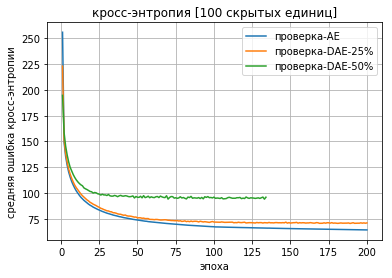

In [19]:
# Частота ошибок
plt.grid()
#plt.plot(*zip(*ae.training_error), label='training-AE')
plt.plot(*zip(*ae.validation_error), label='проверка-AE')
#plt.plot(*zip(*dae25.training_error), label='training-DAE-25%')
plt.plot(*zip(*dae25.validation_error), label='проверка-DAE-25%')
#plt.plot(*zip(*dae50.training_error), label='training-DAE-50%')
plt.plot(*zip(*dae50.validation_error), label='проверка-DAE-50%')
plt.title('кросс-энтропия [100 скрытых единиц]')
plt.xlabel('эпоха')
plt.ylabel('средняя ошибка кросс-энтропии')
plt.legend()
plt.show()

Вышеприведенный график показывает, что ошибка кросс-энтропии при проверке, установленная на 25%, меньше, чем на 50%, но оба они больше, чем не используют автоэнкодирование, не поддерживающий декодирования.

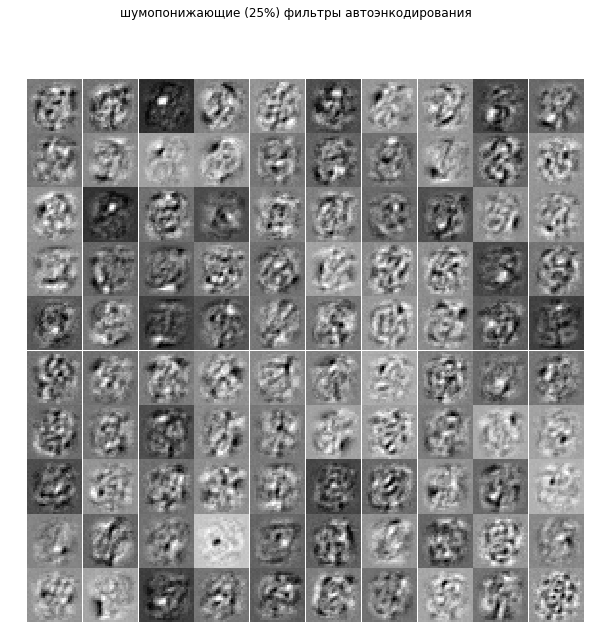

In [20]:
assert dae25.W.shape[0] >= 100
print_image(dae25.W[:100,:], output_shape=(10, 10),
            title='шумопонижающие (25%) фильтры автоэнкодирования')
None

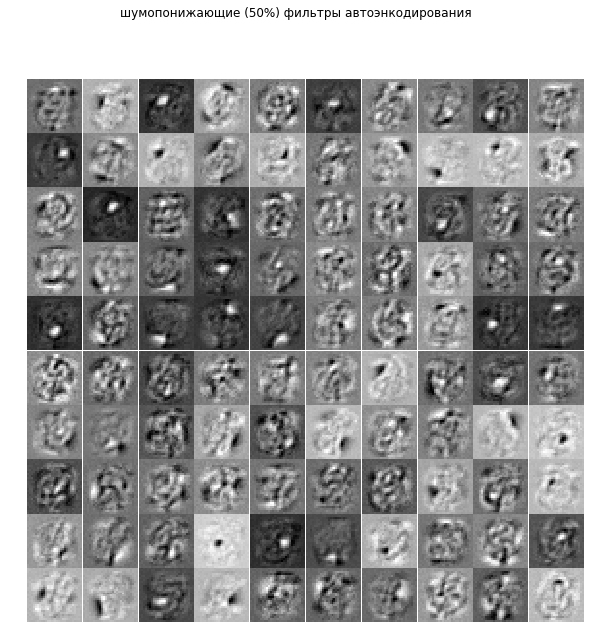

In [21]:
assert dae50.W.shape[0] >= 100
print_image(dae50.W[:100,:], output_shape=(10, 10),
            title='шумопонижающие (50%) фильтры автоэнкодирования')
None

Как видно в классе, 50% DAE, по-видимому, имеют более четкие фильтры, чем 25% DAE, который имеет более четкие фильтры, чем обычный AE. Однако стоит выбрать 25% DAE, поскольку, как представляется, он обеспечивает более высокую точность ошибок проверки.

Использование весов DAE в качестве предварительно подготовленных функций для feedforward классификатора NN.

In [22]:
# Начальная инициализация DAE
nn_dae = NN(architecture=[784, 100, 10], 
            activation='sigmoid', learning_rate=0.01, momentum=0.7,
            weight_decay=1e-4, dropout=0.0, early_stopping=True, 
            seed=40)
nn_dae.layers[0].W = dae25.W
nn_dae.train(X_train, y_train, X_valid, y_valid,
             batch_size=200, n_epoch=n_epoch, batch_seed=25,
             verbose=False)  # silent run
None

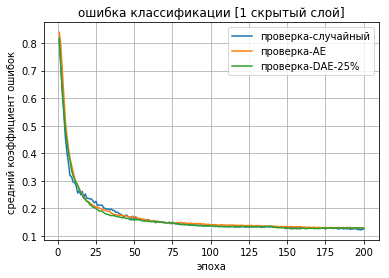

In [23]:
# Частота ошибок
plt.grid()
plt.plot(*zip(*nn_random.validation_error), label='проверка-случайный')
plt.plot(*zip(*nn_ae.validation_error), label='проверка-AE')
plt.plot(*zip(*nn_dae.validation_error), label='проверка-DAE-25%')
plt.title('ошибка классификации [1 скрытый слой]')
plt.xlabel('эпоха')
plt.ylabel('средний коэффициент ошибок')
plt.legend()
plt.show()

Предварительная подготовка с использованием 25%-DAE, по-видимому, немного улучшает ошибку проверки, даже больше, чем AE, в начале обучения (<50 эпох.). Как и раньше, ошибка проверки достоверности, похоже, стабилизируется в этом конкретном наборе данных, потому что на самом деле у есть больший пул немаркированных данных, чтобы исходная NN могла в конечном итоге догнать.

## (g) Количество скрытых единиц * [для AE и DAE] *

###### Смотреть `rbm_mnist.ipynb`  для этого эксперимента с RBM.

Меняется количество скрытых единиц в автоэнкодере.

In [24]:
aes = []
n_hidden_units = [50, 100, 200, 500]
for i, n_hidden in enumerate(n_hidden_units):
    ae0 = Autoencoder(n_visible=784, n_hidden=n_hidden, binary=True,
                      activation='sigmoid', denoising=0.0,
                      learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                      early_stopping=True, seed=2)
    ae0.train(X_train, X_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25, 
              verbose=False)  # silent run
    aes.append(ae0)
    print('AE #{:d} с {:d} скрытами слоями обучение завершено ({:d} эпох)'.format(i, n_hidden, n_epoch))
    print('Финальная ошибка обучения: {:.5f}'.format(ae0.training_error[-1][1]))
    print('Финальная ошибка проверки: {:.5f}'.format(ae0.validation_error[-1][1]))

AE #0 с 50 скрытами слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 80.85098
Финальная ошибка проверки: 91.61322
AE #1 с 100 скрытами слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 48.72875
Финальная ошибка проверки: 64.28247
AE #2 с 200 скрытами слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 22.73228
Финальная ошибка проверки: 40.30451
AE #3 с 500 скрытами слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 6.60822
Финальная ошибка проверки: 18.34965


Использование большего количества единиц напрямую приводит к меньшей ошибке кросс-энтропии, по крайней мере, в течение 200 эпох. Эти ошибки намного лучше, чем то, что получилось от RBM. Ниже приведены некоторые почти идеальные примеры восстановления невидимых данных:

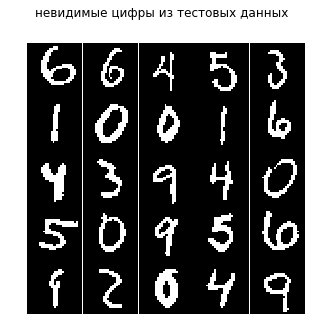

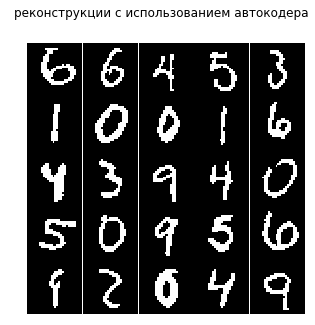

In [25]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_test.shape[0]), 25, replace=False)

X_rec = aes[-1].reconstruct(X_test[subset, :])
print_image(X_test[subset], output_shape=(5, 5),
            title='невидимые цифры из тестовых данных')
print_image(X_rec, output_shape=(5, 5),
            title='реконструкции с использованием автокодера')
None

Изменение количество скрытых единиц для шумоподавления автокодеров.

In [26]:
daes = []
n_hidden_units = [50, 100, 200, 500]
for i, n_hidden in enumerate(n_hidden_units):
    dae0 = Autoencoder(n_visible=784, n_hidden=n_hidden, binary=True,
                      activation='sigmoid', denoising=0.25,
                      learning_rate=0.1, momentum=0.5, weight_decay=1e-4,
                      early_stopping=True, seed=2)
    dae0.train(X_train, X_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25, 
              verbose=False)  # silent run
    daes.append(dae0)
    print('DAE #{:d} с {:d} скрытыми слоями обучение завершено ({:d} эпох)'.format(i, n_hidden, n_epoch))
    print('Финальная ошибка обучения: {:.5f}'.format(dae0.training_error[-1][1]))
    print('Финальная ошибка проверки: {:.5f}'.format(dae0.validation_error[-1][1]))

DAE #0 с 50 скрытыми слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 84.48869
Финальная ошибка проверки: 93.57045
DAE #1 с 100 скрытыми слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 57.72894
Финальная ошибка проверки: 70.89060
======Early stopping: validation error increase at epoch 100=====
DAE #2 с 200 скрытыми слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 39.78890
Финальная ошибка проверки: 53.75490
======Early stopping: validation error increase at epoch 100=====
DAE #3 с 500 скрытыми слоями обучение завершено (200 эпох)
Финальная ошибка обучения: 25.69300
Финальная ошибка проверки: 41.31058


Опять же, ошибка, похоже, улучшается по количеству скрытых единиц. Результаты реконструкции по тому же набору невидимых цифр для 25% DAE с 500 скрытыми единицами. Результаты тоже неплохие.

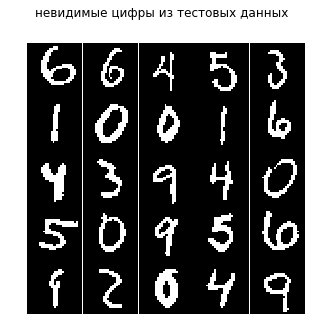

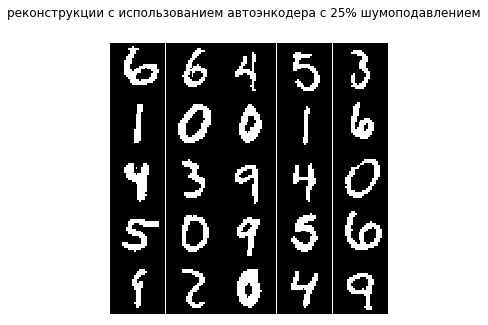

In [27]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_test.shape[0]), 25, replace=False)

X_rec = daes[-1].reconstruct(X_test[subset, :])
print_image(X_test[subset], output_shape=(5, 5),
            title='невидимые цифры из тестовых данных')
print_image(X_rec, output_shape=(5, 5),
            title='реконструкции с использованием автоэнкодера с 25% шумоподавлением')
None

Cравнение фильтров лучших AE и лучших 25%-DAE.

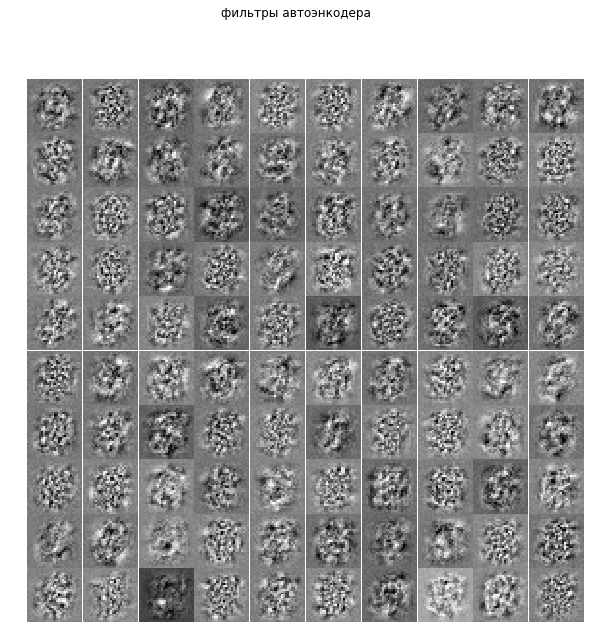

In [28]:
assert aes[-1].W.shape[0] >= 100
print_image(aes[-1].W[:100,:], output_shape=(10, 10),
            title='фильтры автоэнкодера')
None

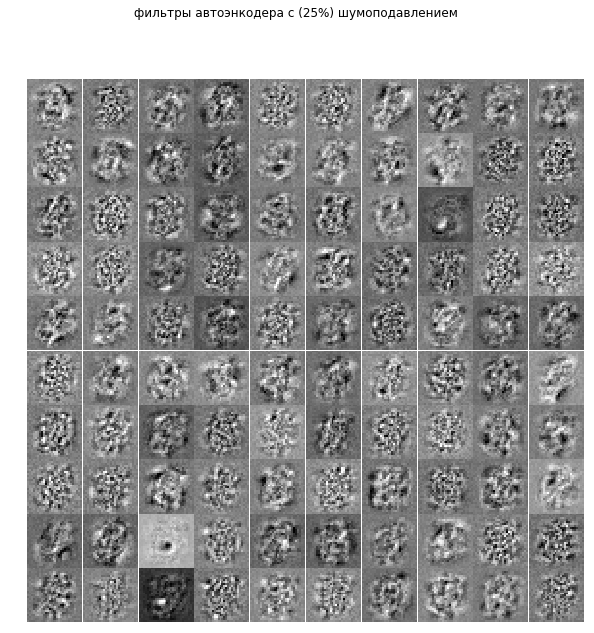

In [29]:
assert daes[-1].W.shape[0] >= 100
print_image(daes[-1].W[:100,:], output_shape=(10, 10),
            title='фильтры автоэнкодера с (25%) шумоподавлением')
None

Ни один из фильтров не похож на конкретную фигуру, но видно, что она довольно резкая в разных моделях (довольно много черных / белых значений). По сравнению с фильтрами RBM они занимали меньше времени, чтобы найти насыщенные фильтры и хорошо восстановить невидимый пример, хотя RBM могут генерировать новые цифровые структуры, видя аналогичный объем данных.